In [83]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

# NYC 311 Calls: An exploratory analysis of calls received in 2016

NYC 311 is a government organization that aims to provide the public with access to city services and information, and it allows city residents to make non-emergency complaints, such as a landlord not providing sufficient heat, or needing snow removed from an area along the sidewalk. We wanted to determine the relationship between the volume of NYC 311 calls and area demographics, hypothesizing that lower income areas would be more likely to be neglected by city agencies, leading to a larger number of NYC 311 calls in these areas. In order to begin our regression analysis, we explored the data available, ultimately choosing to utilize NYC OpenData for NYC 311 call information and the U.S. Census Bureau's American FactFinder for 2016 ACS information surrouding population, income, and rent. With our regression model, we hoped to be able to predict the number of 311 calls based on population demographics.  

# Data Cleaning

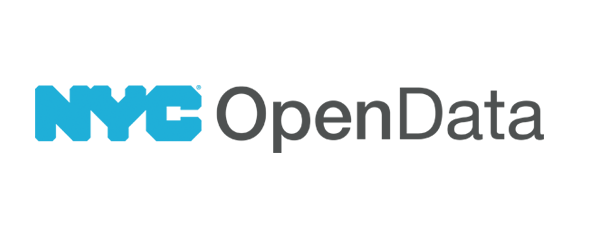

In [84]:
from IPython.display import Image
from IPython.display import display 

x = Image('open_data.png')
display(x)

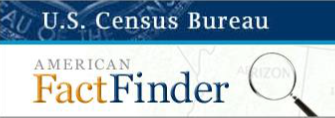

In [85]:
y = Image('acs.png')
display(y)

In [86]:
q1_df = pd.read_csv('/Users/kaylahartman/Documents/Project_Two/311q1.csv')
q2_df = pd.read_csv('/Users/kaylahartman/Documents/Project_Two/311q2.csv')
q3_df = pd.read_csv('/Users/kaylahartman/Documents/Project_Two/311q3.csv')
q4_df = pd.read_csv('/Users/kaylahartman/Documents/Project_Two/311q4.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
#combining quarterly DataFrames to one DataFrame for all of 2016
open_data_df = pd.concat([q1_df, q2_df, q3_df, q4_df])
open_data_df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,32305299,01/01/2016 12:00:09 AM,01/01/2016 01:57:32 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11201.0,102 GOLD STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.701823,-73.982840,"(40.70182309943841, -73.98284003196223)"
1,32310343,01/01/2016 12:00:40 AM,01/01/2016 03:12:53 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10468.0,3155 GRAND CONCOURSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.875565,-73.886111,"(40.87556453341452, -73.88611123391182)"
2,32309107,01/01/2016 12:01:09 AM,01/21/2016 09:20:55 AM,HPD,Department of Housing Preservation and Develop...,ELECTRIC,NO LIGHTING,RESIDENTIAL BUILDING,10467.0,3572 DEKALB AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.884277,-73.878885,"(40.8842770627239, -73.87888510394457)"
3,32308578,01/01/2016 12:02:59 AM,01/01/2016 11:35:50 PM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,NaN,539 SIXTH AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32309212,01/01/2016 12:03:03 AM,01/08/2016 01:13:00 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10458.0,2345 TIEBOUT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.857841,-73.896607,"(40.85784092074736, -73.8966070485658)"


In [88]:
#importing csvs for population, income, and rent 
pop_df = pd.read_csv('ACS_16_Pop.csv', header=[1])
income_df = pd.read_csv('ACS_16_Income.csv', header=[1])
rent_df = pd.read_csv('ACS_16_Rent.csv', header=[1])

In [89]:
#cleaning population, income, and rent DataFrames
pop_df = pop_df.drop(columns=['Id', 'Geography', 'Margin of Error; Total'])
pop_df = pop_df.drop(pop_df.index[0])
pop_df = pop_df.drop(pop_df.index[0])
pop_df = pop_df.rename(index=str, columns={'Id2': 'Zip Code', 'Estimate; Total': 'Population Estimate'})

income_df = income_df.drop(income_df.columns[0], axis=1)
income_df = income_df.drop(income_df.columns[1], axis=1)
income_df = income_df.drop(income_df.columns[1], axis=1)
income_df = income_df.drop(income_df.columns[1], axis=1)
income_df = income_df.drop(income_df.columns[2:120], axis=1)
income_df = income_df.drop(income_df.index[0])
income_df = income_df.drop(income_df.index[0])
income_df = income_df.rename(index=str, columns={'Id2': 'Zip Code', 'Median income (dollars); Estimate; Households': 'Median Estimate'})

rent_df = rent_df.drop(columns=['Id', 'Geography', 'Margin of Error; Median gross rent'])
rent_df = rent_df.drop(rent_df.index[0])
rent_df = rent_df.drop(rent_df.index[0])
rent_df = rent_df.rename(index=str, columns={'Id2': 'Zip Code', 'Estimate; Median gross rent': 'Gross Rent Estimate'})

In [90]:
pop_df.head()

,Zip Code,Population Estimate
2,10001,23332
3,10002,78096
4,10003,56767
5,10004,3044
6,10005,8710


In [91]:
income_df.head()

,Zip Code,Median Estimate
2,10001,85168
3,10002,35594
4,10003,100791
5,10004,123056
6,10005,130116


In [92]:
rent_df.head()

,Zip Code,Gross Rent Estimate
2,10001,2114
3,10002,919
4,10003,2117
5,10004,2911
6,10005,3005


In [93]:
rentandincome = pd.merge(rent_df, income_df, on='Zip Code')
data = pd.merge(rentandincome, pop_df, on='Zip Code')

open_data_df = open_data_df[open_data_df['Incident Zip'].notnull()]

open_data_df['Zip Code'] = open_data_df['Incident Zip'].astype(np.int64)

final_open_data_df = open_data_df.drop(['Unique Key', 'Location', 'Closed Date','Agency Name', 'Descriptor', 'Location Type', 'Incident Address', 'Street Name', 'Cross Street 1','Cross Street 2', 'Intersection Street 1', 'Intersection Street 2','Address Type', 'City', 'Landmark', 'Facility Type', 'Status','Due Date', 'Resolution Description', 'Resolution Action Updated Date','Community Board', 'BBL','X Coordinate (State Plane)','Y Coordinate (State Plane)', 'Open Data Channel Type','Park Facility Name', 'Park Borough', 'Vehicle Type','Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name','Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment','Latitude', 'Longitude'], axis = 1)

df = pd.merge(final_open_data_df, data, left_on='Zip Code', right_on='Zip Code')

In [94]:
#removed any excess characters and ensured we had the correct data types 
df = df[df['Gross Rent Estimate'] != '-']
df = df[df['Gross Rent Estimate'] != 0]
df = df[df['Median Estimate'] != '-']
df = df[df['Median Estimate'] != 0]
df = df[df['Population Estimate'] != 0]
df = df[df['Borough'] != 'Unspecified']

df['Created Date'] = df['Created Date'].apply(lambda x: str(x).split(' ')[0])
df['Created Date'] = df['Created Date'].apply(lambda x: str(x).split('/')[0])
df['Created Date'] = df['Created Date'].apply(lambda x: int(x))

df['Median Estimate'] = df['Median Estimate'].apply(lambda x: str(x).split('+')[0])
df['Gross Rent Estimate'] = df['Gross Rent Estimate'].apply(lambda x: str(x).split('+')[0])

df['Gross Rent Estimate'] = df['Gross Rent Estimate'].apply(lambda x: int(x))

df['Median Estimate'] = df['Median Estimate'].apply(lambda x: x.strip(','))

df['Median Estimate'] = df['Median Estimate'].replace('250,000', '250000')

df['Median Estimate'] = df['Median Estimate'].apply(lambda x: int(x))

conditions = [(df['Created Date'] == 1), (df['Created Date'] == 2), (df['Created Date'] == 3), (df['Created Date'] == 4), (df['Created Date'] == 5), (df['Created Date'] == 6), (df['Created Date'] == 7), (df['Created Date'] == 8), (df['Created Date'] == 9), (df['Created Date'] == 10), (df['Created Date'] == 11), (df['Created Date'] == 12)]
choices = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
df['Created Date'] = np.select(conditions, choices, default='black')

df_all = df

After using Pandas to create DataFrames with our data, we cleaned the data and merged the DataFrames to show the population demographics associated with each NYC 311 call based on zip code. During this process, there were at least a dozen times in which we strongly believed we were done with cleaning the data, but we would then notice another necessary data cleaning step. 

In [95]:
df_all.head()

,Created Date,Agency,Complaint Type,Incident Zip,Borough,Zip Code,Gross Rent Estimate,Median Estimate,Population Estimate
0,Winter,NYPD,Noise - Street/Sidewalk,11201.0,BROOKLYN,11201,2103,109472,60061
1,Winter,NYPD,Noise - Residential,11201.0,BROOKLYN,11201,2103,109472,60061
2,Winter,NYPD,Noise - Residential,11201.0,BROOKLYN,11201,2103,109472,60061
3,Winter,NYPD,Noise - Residential,11201.0,BROOKLYN,11201,2103,109472,60061
4,Winter,NYPD,Noise - Street/Sidewalk,11201.0,BROOKLYN,11201,2103,109472,60061


In [96]:
len(df_all)

1847866

At this point, we were extremely confident with our DataFrame and were about to start regression analysis. However, we realized that each row is associated with a single 311 call, yet our goal was to predict the number of 311 calls based on population demographics. In order to do this, we then grouped the data by zip code and created a new column that showed the count of 311 calls in each zip code for every season. Once we did this, we also created dummy variables for the seasons and boroughs. 

In [97]:
#created count_zip_code column and grouped data
df_winter = df_all[df_all['Created Date'] == 'Winter']
df_spring = df_all[df_all['Created Date'] == 'Spring']
df_summer = df_all[df_all['Created Date'] == 'Summer']
df_fall = df_all[df_all['Created Date'] == 'Fall']


df_winter = df_winter.groupby(['Created Date', 'Gross Rent Estimate', 'Median Estimate', 'Population Estimate', 'Borough'], as_index=False)['Zip Code'].count()
df_spring = df_spring.groupby(['Created Date', 'Gross Rent Estimate', 'Median Estimate', 'Population Estimate', 'Borough'], as_index=False)['Zip Code'].count()
df_summer = df_summer.groupby(['Created Date', 'Gross Rent Estimate', 'Median Estimate', 'Population Estimate', 'Borough'], as_index=False)['Zip Code'].count()
df_fall = df_fall.groupby(['Created Date', 'Gross Rent Estimate', 'Median Estimate', 'Population Estimate', 'Borough'], as_index=False)['Zip Code'].count()

df_all_seasons = pd.concat([df_winter, df_spring, df_summer, df_fall], axis = 0)

#created dummy variables for our categorical variables - seasons and boroughs 
dummies = pd.get_dummies(df_all_seasons['Created Date'])
dummies.head()
df_all_seasons = pd.concat([df_all_seasons, dummies], axis=1)

borough_dummies = pd.get_dummies(df_all_seasons['Borough'])
df_all_seasons = pd.concat([df_all_seasons, borough_dummies], axis=1)

df_all_seasons['count_zip_code'] = df_all_seasons['Zip Code']
df_all_seasons = df_all_seasons.rename(index=str, columns={'Created Date': 'created_date', 'Gross Rent Estimate': 'gross_rent', 'Median Estimate': 'income', 'Population Estimate': 'pop', 'Zip Code': 'zip', 'Fall': 'fall', 'Spring': 'spring', 'Summer': 'summer', 'Winter': 'winter', 'BRONX': 'bronx', 'BROOKLYN': 'brooklyn', 'MANHATTAN': 'manhattan', 'QUEENS': 'queens', 'STATEN ISLAND': 'staten_island'})

df_all_seasons = df_all_seasons[df_all_seasons['count_zip_code'] > 10]

## Here is our final DataFrame

In [98]:
df_all_seasons.head()

,created_date,gross_rent,income,pop,Borough,zip,fall,spring,summer,winter,bronx,brooklyn,manhattan,queens,staten_island,count_zip_code
0,Winter,645,24610,12468,BROOKLYN,411,0,0,0,1,0,1,0,0,0,411
1,Winter,705,21553,38938,BRONX,2272,0,0,0,1,1,0,0,0,0,2272
2,Winter,744,31371,43444,BROOKLYN,1895,0,0,0,1,0,1,0,0,0,1895
3,Winter,758,26893,34187,MANHATTAN,2385,0,0,0,1,0,0,1,0,0,2385
4,Winter,851,23962,42779,BRONX,2887,0,0,0,1,1,0,0,0,0,2887


# Exploratory Data Analysis

Before beginning our regression analysis, we needed to better understand our data and chose to analyze the way in which the dependent variables interact with the explanatory variable through visualizations and collinearity analysis. 

Our Questions: 
    1. Is there a relationship between the number of 311 calls and selected area demographics? 
    2. What appears to be the best represenation for each independent variable?
    3. Is there a borough in which we see the largest number of 311 calls? 
    4. Is there a season in which we see the largest number of 311 calls?

In [99]:
df = pd.read_csv('df_regression.csv')
df = df.drop(['Unnamed: 0'], axis=1)

data_pred = df.copy()
data_pred = data_pred.drop(columns=['created_date', 'zip', 'Borough'])
data_pred.head()

,gross_rent,income,pop,fall,spring,summer,winter,bronx,brooklyn,manhattan,queens,staten_island,count_zip_code
0,645,24610,12468,0,0,0,1,0,1,0,0,0,411
1,705,21553,38938,0,0,0,1,1,0,0,0,0,2272
2,744,31371,43444,0,0,0,1,0,1,0,0,0,1895
3,758,26893,34187,0,0,0,1,0,0,1,0,0,2385
4,851,23962,42779,0,0,0,1,1,0,0,0,0,2887


In [100]:
#Correlation function applied to determine collinearity 
data_pred.corr()

,gross_rent,income,pop,fall,spring,summer,winter,bronx,brooklyn,manhattan,queens,staten_island,count_zip_code
gross_rent,1.000000,0.869473,-0.438015,0.002624,-0.001114,-0.002245,0.000738,-0.279082,-0.175563,0.524909,-0.042454,-0.153342,-0.393206
income,0.869473,1.000000,-0.488446,0.002519,-0.001187,-0.002219,0.000890,-0.270258,-0.199882,0.452973,-0.058274,0.032610,-0.485080
pop,-0.438015,-0.488446,1.000000,0.002910,0.001546,0.001442,-0.005909,0.116260,0.406091,-0.228616,-0.187176,-0.081312,0.729236
fall,0.002624,0.002519,0.002910,1.000000,-0.332744,-0.335101,-0.332744,-0.000306,-0.004123,0.004896,-0.000547,-0.000199,-0.021451
spring,-0.001114,-0.001187,0.001546,-0.332744,1.000000,-0.333918,-0.331570,0.000918,-0.002530,-0.000472,0.001645,0.000599,-0.023048
summer,-0.002245,-0.002219,0.001442,-0.335101,-0.333918,1.000000,-0.333918,-0.001525,0.001723,-0.003948,0.003715,-0.000994,-0.029021
winter,0.000738,0.000890,-0.005909,-0.332744,-0.331570,-0.333918,1.000000,0.000918,0.004931,-0.000472,-0.004825,0.000599,0.073661
bronx,-0.279082,-0.270258,0.116260,-0.000306,0.000918,-0.001525,0.000918,1.000000,-0.208909,-0.227706,-0.286283,-0.104145,0.264151
brooklyn,-0.175563,-0.199882,0.406091,-0.004123,-0.002530,0.001723,0.004931,-0.208909,1.000000,-0.297768,-0.374369,-0.136189,0.334014
manhattan,0.524909,0.452973,-0.228616,0.004896,-0.000472,-0.003948,-0.000472,-0.227706,-0.297768,1.000000,-0.408054,-0.148443,-0.122133


In [101]:
abs(data_pred.corr()) > .75

,gross_rent,income,pop,fall,spring,summer,winter,bronx,brooklyn,manhattan,queens,staten_island,count_zip_code
gross_rent,True,True,False,False,False,False,False,False,False,False,False,False,False
income,True,True,False,False,False,False,False,False,False,False,False,False,False
pop,False,False,True,False,False,False,False,False,False,False,False,False,False
fall,False,False,False,True,False,False,False,False,False,False,False,False,False
spring,False,False,False,False,True,False,False,False,False,False,False,False,False
summer,False,False,False,False,False,True,False,False,False,False,False,False,False
winter,False,False,False,False,False,False,True,False,False,False,False,False,False
bronx,False,False,False,False,False,False,False,True,False,False,False,False,False
brooklyn,False,False,False,False,False,False,False,False,True,False,False,False,False
manhattan,False,False,False,False,False,False,False,False,False,True,False,False,False


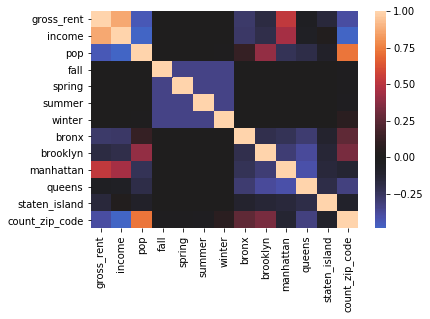

In [102]:
#created heatmap matrix to determine collinearity 
sns.heatmap(data_pred.corr(), center = 0)

## What appears to be the best representation for each independent variable? 

After looking at the below distributions, rent and income appeared to be postively skewed. We ultimately found the population variable appeared to most closely be normally distributed without taking its log, while the income and rent variables appeared to most closely be normaly distrbuted when taking their logs. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c31a46208>,
      dtype=object)

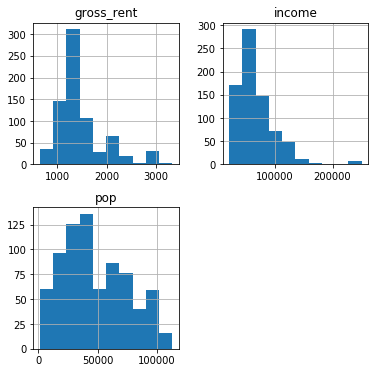

In [103]:
data = df
data[['created_date', 'gross_rent', 'income', 'pop', ]].hist(figsize  = [6, 6])

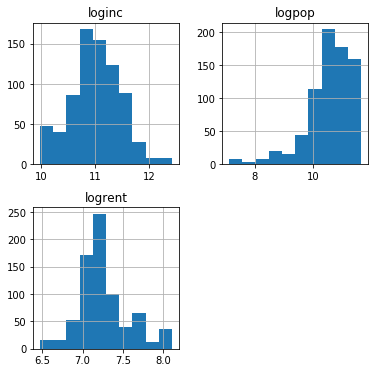

In [104]:
data_log = pd.DataFrame([])
data_log['logrent'] = np.log(data['gross_rent'])
data_log['loginc'] = np.log(data['income'])
data_log['logpop'] = np.log(data['pop'])
data_log.hist(figsize  = [6, 6]);

## Is there a borough in which we see the largest number of 311 calls? 

Based on the below scatterplot and boxplot, we see that the borough with the highest median number of 311 calls is Brooklyn, yet the borough with the highest range of 311 calls is the Bronx. 

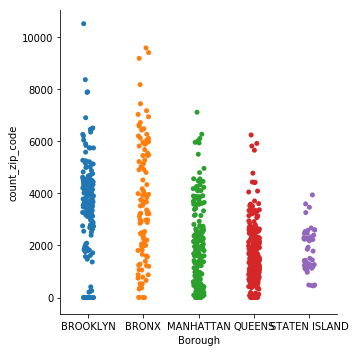

In [105]:
borough_plot = df.drop(['created_date', 'gross_rent', 'income', 'pop', 'zip', 'bronx', 'brooklyn', 'manhattan', 'queens', 'staten_island', 'winter', 'spring', 'summer', 'fall'], axis=1)
sns.catplot(x='Borough', y='count_zip_code', data=borough_plot);

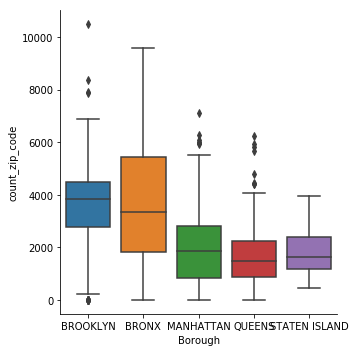

In [106]:
sns.catplot(x='Borough', y='count_zip_code', kind="box", data=borough_plot);

## Is there a season in which we see the largest number of 311 calls?

All seasons have very similar medians, but winter has the highest Q3 and max. 

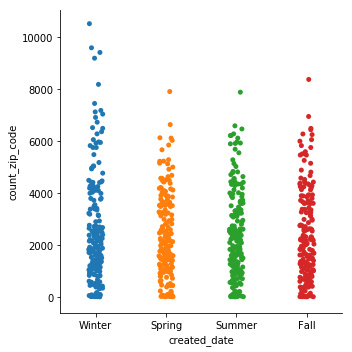

In [107]:
season_plot = df.drop(['Borough', 'gross_rent', 'income', 'pop', 'zip', 'bronx', 'brooklyn', 'manhattan', 'queens', 'staten_island', 'winter', 'spring', 'summer', 'fall'], axis=1)
sns.catplot(x='created_date', y='count_zip_code', data=season_plot);

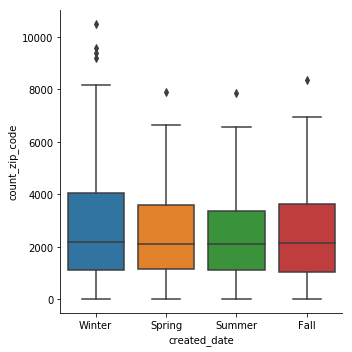

In [108]:
sns.catplot(x='created_date', y='count_zip_code', kind="box", data=season_plot);

## Is there a relationship between the number of 311 calls and selected area demographics? 

The higher the rent, it appears there are fewer 311 calls. However, we noticed this inverse relationship is not linear and appears to have a logarithmic shape.  

Text(0,0.5,'Number of 311 Calls')

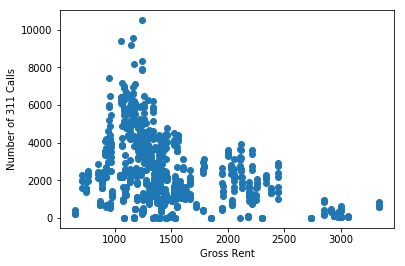

In [109]:
plt.scatter(df['gross_rent'], df['count_zip_code'])
plt.xlabel('Gross Rent')
plt.ylabel('Number of 311 Calls')

The higher the income, it appears there are fewer 311 calls. However, we noticed this inverse relationship is not linear and appears to have a logarithmic shape.

Text(0,0.5,'Number of 311 Calls')

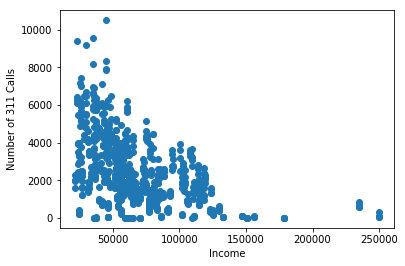

In [110]:
plt.scatter(df['income'], df['count_zip_code'])
plt.xlabel('Income')
plt.ylabel('Number of 311 Calls')

There appears to be a direct linear relationship between population and the number of 311 calls. 

Text(0,0.5,'Number of 311 Calls')

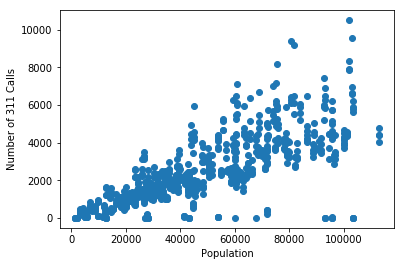

In [111]:
plt.scatter(df['pop'], df['count_zip_code'])
plt.xlabel('Population')
plt.ylabel('Number of 311 Calls')

# Regression Analysis

Before making any changes to our model, we ran an OLS regression with population, income, rent, season dummies, and borough dummies as our independent variables, and we observed the below results. With this regression we found an R-squared value of .623, meaning our model explains 62.3% of the variation in the number of 311 calls relative to our independent variables. Unfortunately, we noticed that two of our p values were >.05, meaning the associated coefficient values are not significant. 

In [112]:
data_ols = data_pred.copy()
outcome = 'count_zip_code'
predictors = data_ols.drop('count_zip_code', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum + " -1" 
model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         count_zip_code   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     123.1
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          2.48e-150
Time:                        14:15:35   Log-Likelihood:                -6365.8
No. Observations:                 755   AIC:                         1.275e+04
Df Residuals:                     744   BIC:                         1.280e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
gross_rent        0.4949      0.183      2.704      0.007       0.136       0.854
income           -0.0163      0.003     -6.223      0.000      -0.021      -0.011
pop               0.0394      0.002     21.162      0.000       0.036       0.043
fall            496.8733    135.347      3.671      0.000     231.166     762.581
spring          493.5310    135.253      3.649      0.000     228.008     759.054
summer          477.0825    134.986      3.534      0.000     212.084     742.081
winter          808.3937    134.888      5.993      0.000     543.587    1073.201
bronx          1039.6967    127.297      8.167      0.000     789.793    1289.601
brooklyn        551.9690    139.600      3.954      0.000     277.912     826.026
manhattan       613.1853    154.222      3.976      0.000     310.423     915.947
queens         -211.0494    110.126     -1.916      0.056    -427.245       5.146
staten_island   282.0788    159.535      1.768      0.077     -31.113     595.271
==============================================================================
Omnibus:                      103.560   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              607.910
Skew:                          -0.443   Prob(JB):                    9.86e-133
Kurtosis:                       7.306   Cond. No.                     1.02e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.49e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

After completing a variety of model iterations, and with our knowledge of the relationship between the independent variables and the explanatory variable, we ultimately found our strongest results were when we also added log(rent) and log(income) in our model. In doing so, we found the below OLS regression results. In this model, our R-squared value increased to .649, meaning our model explains 64.9% of the variation in the number of 311 calls relative to our independent variables. In this model, we also had all p values <.05. 

In [113]:
log_data_ols = data_pred.copy()

log_data_ols['log_gross_rent']=np.log(log_data_ols['gross_rent'])
log_data_ols['log_income']=np.log(log_data_ols['income'])

outcome = 'count_zip_code'
predictors = log_data_ols.drop(['count_zip_code', ], axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum + " -1" 
model = ols(formula= formula, data=log_data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         count_zip_code   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     114.4
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          1.15e-159
Time:                        14:15:35   Log-Likelihood:                -6338.8
No. Observations:                 755   AIC:                         1.270e+04
Df Residuals:                     742   BIC:                         1.276e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
gross_rent        -3.3863      0.625     -5.416      0.000      -4.614      -2.159
income             0.0175      0.005      3.247      0.001       0.007       0.028
pop                0.0342      0.002     17.530      0.000       0.030       0.038
fall           -6274.6127   2467.325     -2.543      0.011   -1.11e+04   -1430.843
spring         -6278.2411   2467.177     -2.545      0.011   -1.11e+04   -1434.763
summer         -6294.6898   2467.349     -2.551      0.011   -1.11e+04   -1450.874
winter         -5964.4035   2467.685     -2.417      0.016   -1.08e+04   -1119.928
bronx          -4679.5067   1963.898     -2.383      0.017   -8534.964    -824.049
brooklyn       -4863.3260   1975.920     -2.461      0.014   -8742.386    -984.266
manhattan      -4760.3279   1956.758     -2.433      0.015   -8601.769    -918.887
queens         -5706.9016   2002.111     -2.850      0.004   -9637.379   -1776.425
staten_island  -4801.8848   1981.234     -2.424      0.016   -8691.376    -912.393
log_gross_rent  6958.0507   1044.203      6.664      0.000    4908.107    9007.994
log_income     -3133.9452    439.928     -7.124      0.000   -3997.596   -2270.294
==============================================================================
Omnibus:                      120.486   Durbin-Watson:                   2.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              680.102
Skew:                          -0.576   Prob(JB):                    2.08e-148
Kurtosis:                       7.505   Cond. No.                     9.76e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.98e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

After discovering that the model appeared strongest when adding log(rent) and log(income) based on OLS, we completed train-test-split analysis with .20 as our test size. We found a very large RMSE, suggesting that in the end, our model does not accurately predict the target values. 

In [114]:
y = log_data_ols.count_zip_code
X = log_data_ols.drop(['count_zip_code'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 32, test_size=0.20)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

rmse_train = np.sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
rmse_test = np.sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

Train Root Mean Squarred Error: 1049.3351175643063
Test Root Mean Squarred Error: 1169.150665502266


In [115]:
rmse_train_z = rmse_train/np.std(y_train)
rmse_test_z = rmse_test/np.std(y_test)
print('Z Train Root Mean Squarred Error:', rmse_train_z)
print('Z Test Root Mean Squarred Error:', rmse_test_z)

Z Train Root Mean Squarred Error: 0.5910743561088311
Z Test Root Mean Squarred Error: 0.6054304715898661


When we found our mean absolute error for teh train and test data, we saw that on average we are 703.76 from the mean 2,408.98 for the test data and that on average we are 758.34 away from the mean for the test data. 

In [116]:
mae_train = (np.sum(abs(y_train-y_hat_train)))/len(y_train)
mae_test = (np.sum(abs(y_test-y_hat_test)))/len(y_test)
print('Train Mean Absolute Error:', mae_train)
print('Train Mean Absolute Error:', mae_test)

print('  ')

y_train_mean = y_train.mean()
y_test_mean = y_test.mean()
print('Y Train Mean:', y_train_mean)
print('Y Test Mean', y_test_mean)

Train Mean Absolute Error: 703.76164033026
Train Mean Absolute Error: 758.3384754842499
  
Y Train Mean: 2408.978476821192
Y Test Mean 2601.609271523179


We plotted overlapping distributions for our y_train and y_test to vizualize the difference between their distributions. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


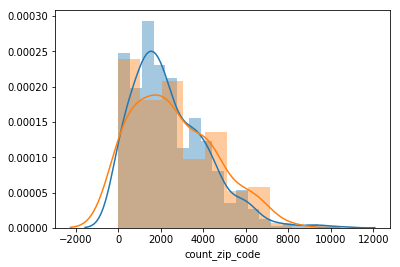

In [117]:
sns.distplot(y_train)
sns.distplot(y_test)

We completed a regression analysis and then plotted the predictions and true values. Based on the scatter plot we can see that there are outlier in our true prediction results which may be in effect affecting to increase our RMSE.

Text(0,0.5,'Predictions')

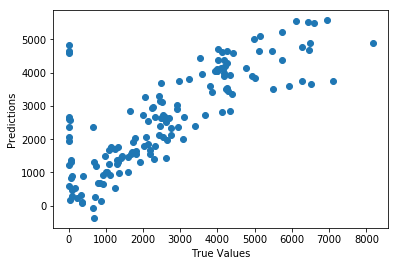

In [118]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

We did the cross-validation which was 1131.39 to compare our train-test-split test RMSE which was 1169.15. They are both ver close to each other.

In [129]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
np.sqrt(cv_5_results* (-1) )

1131.3996116217295